# Employee Churn Prediction

In this notebook, we import employee churn dataset from a telcom company, and model for churn prediction. 

# Importing libraries

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector as ColumnSelector
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, NMF
from sklearn.metrics import log_loss,confusion_matrix,classification_report, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

import lightgbm
from lightgbm import LGBMClassifier

from hyperopt import hp, tpe, fmin, STATUS_OK, Trials

import shap
from shap import KernelExplainer, summary_plot

# Load Data

In [ ]:
df = pd.read_csv("/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#Select only required columns. We could drop columns like- "customerID" which is not required for the pipeline

df= df.drop('customerID', axis=1)

In [ ]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

# Preprocessing Data

In [ ]:
df.shape

(7043, 20)

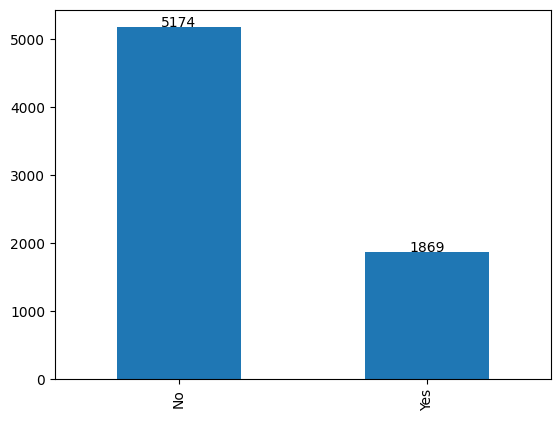

In [ ]:
#Shape of lables

counts = df['Churn'].value_counts()
ax = counts.plot(kind='bar')
for i, v in enumerate(counts):
    ax.text(i, v + 10, str(v), ha='center')

plt.show()

#We can see that there is class imbalance in the prediction label.
#Hence, we employ over sampling on minorty class in the pipeline to be defined below.

### Datatype conversions

In [ ]:
obj_cols= ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod','Churn']
for col in obj_cols:
  df[col]= df[col].astype(str)


num_cols= ['tenure','MonthlyCharges', 'TotalCharges']
for col in num_cols:
  df[col]= pd.to_numeric(df[col],errors='coerce')

In [ ]:
df.isnull().sum() #Looking for null values

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
#Drop null values in column 'TotalCharges'

df= df.dropna()
df.shape

(7032, 20)

### Create a pipeline for preprocessing

In [ ]:
#list of different types of columns
bool_cols=["gender", "Partner", "PaperlessBilling", "PhoneService", "Dependents", "SeniorCitizen"]
category_cols=["Contract", "DeviceProtection", "InternetService", "MultipleLines", "OnlineBackup",
               "OnlineSecurity", "PaymentMethod", "StreamingMovies", "StreamingTV", "TechSupport"]
num_cols=["MonthlyCharges", "tenure", "TotalCharges"]

In [ ]:
#Bundle preprocessing for numerical and categorical data

preprocessor = ColumnTransformer(
    transformers=[
        
        ("boolean", OneHotEncoder(handle_unknown="ignore", drop="first"), bool_cols),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="infrequent_if_exist"), category_cols),
        ("standardizer", StandardScaler(), num_cols)
    ], remainder="passthrough", sparse_threshold=1)

preprocessor

ColumnTransformer(remainder='passthrough', sparse_threshold=1,
                  transformers=[('boolean',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['gender', 'Partner', 'PaperlessBilling',
                                  'PhoneService', 'Dependents',
                                  'SeniorCitizen']),
                                ('one_hot_encoder',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                 ['Contract', 'DeviceProtection',
                                  'InternetService', 'MultipleLines',
                                  'OnlineBackup', 'OnlineSecurity',
                                  'PaymentMethod', 'StreamingMovies',
                                  'StreamingTV', 'TechSupport']),
                                ('standardizer', StandardScaler(),
                                 ['MonthlyCharges', 'tenure', 'TotalCharges'])])

# Train-Validation-Test split

In [ ]:
X=df.drop('Churn', axis=1)
y=df['Churn']

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.05, stratify=y_train, random_state=44)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(5343, 19) (5343,)
(282, 19) (282,)
(1407, 19) (1407,)


# Train the classifier model

Create a separate pipeline to transform the validation dataset. This is used for early stopping.

In [ ]:
pipeline_val = Pipeline([
    ("preprocessor", preprocessor)
])

pipeline_val.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=1,
                                   transformers=[('boolean',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'PaperlessBilling',
                                                   'PhoneService', 'Dependents',
                                                   'SeniorCitizen']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Contract',
                                                   'DeviceProtection',
                                                   'InternetService',
                                                   'MultipleLines',
                                                   'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'PaymentMethod',
                                                   'StreamingMovies',
                                                   'StreamingTV',
                                                   'TechSupport']),
                                                 ('standardizer',
                                                  StandardScaler(),
                                                  ['MonthlyCharges', 'tenure',
                                                   'TotalCharges'])]))])

In [ ]:
#Validation set processed
X_val_processed = pipeline_val.transform(X_val)
X_val_processed.shape

(282, 40)

## Define objective function

In [ ]:
def objective(params):
  lgbmc_classifier = LGBMClassifier()

  #Since there is class imbalance in the dataset, apply oversampling using SMOTE in the pipeline
  smt = SMOTE(random_state=42, sampling_strategy=1)

  #Model Pipeline
  model = imbPipeline(steps=[('preprocessor', preprocessor),
                            ('smote', smt),
                            ('classifier', lgbmc_classifier)
                          ])  

  #Model Fit
  model.fit(X_train, y_train,classifier__callbacks=[lightgbm.early_stopping(5), lightgbm.log_evaluation(0)], classifier__eval_set=[(X_val_processed,y_val)])

  #Predictions
  y_pred = model.predict(X_test)

  #Mapping labels to binary values
  y_test_mapped = y_test.map({'Yes': 1, 'No': 0})
  map_func = np.vectorize(lambda x: 1 if x == 'Yes' else 0)
  y_pred_mapped= map_func(y_pred)

  #Loss
  loss = log_loss(y_test_mapped, y_pred_mapped)
  
  return {'loss': loss, 'status': STATUS_OK,'model':model}

## Hyperparameter Tuning

In [ ]:
space = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'learning_rate': hp.loguniform('learning_rate', -5.0, 0),
    'n_estimators': hp.choice('n_estimators', range(1, 1000)),
    'num_leaves': hp.choice('num_leaves', range(2, 100)),
}

In [ ]:
#Seaarching the hyperparameter space using hyperopt 

trials= Trials()
fmin(objective,
     space=space,
     algo=tpe.suggest,
     max_evals=10,  # could be increased if widening the hyperparameter search space.
     trials=trials)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.447059
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.447059
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.447059
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.447059
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.447059
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.447059
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.447059
Training until validation scores don't improve for 5 ro

{'learning_rate': 0.07150538582422764,
 'max_depth': 18,
 'n_estimators': 793,
 'num_leaves': 66}

In [ ]:
best_result = trials.best_trial["result"]
model = best_result["model"]

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=1,
                                   transformers=[('boolean',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'PaperlessBilling',
                                                   'PhoneService', 'Dependents',
                                                   'SeniorCitizen']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Contract',
                                                   'DeviceProtection',
                                                   'InternetService',
                                                   'MultipleLines',
                                                   'OnlineBackup',
                                                   'OnlineSecurity',
                                                   'PaymentMethod',
                                                   'StreamingMovies',
                                                   'StreamingTV',
                                                   'TechSupport']),
                                                 ('standardizer',
                                                  StandardScaler(),
                                                  ['MonthlyCharges', 'tenure',
                                                   'TotalCharges'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('classifier', LGBMClassifier())])

## Feature Importance

  0%|          | 0/100 [00:00<?, ?it/s]

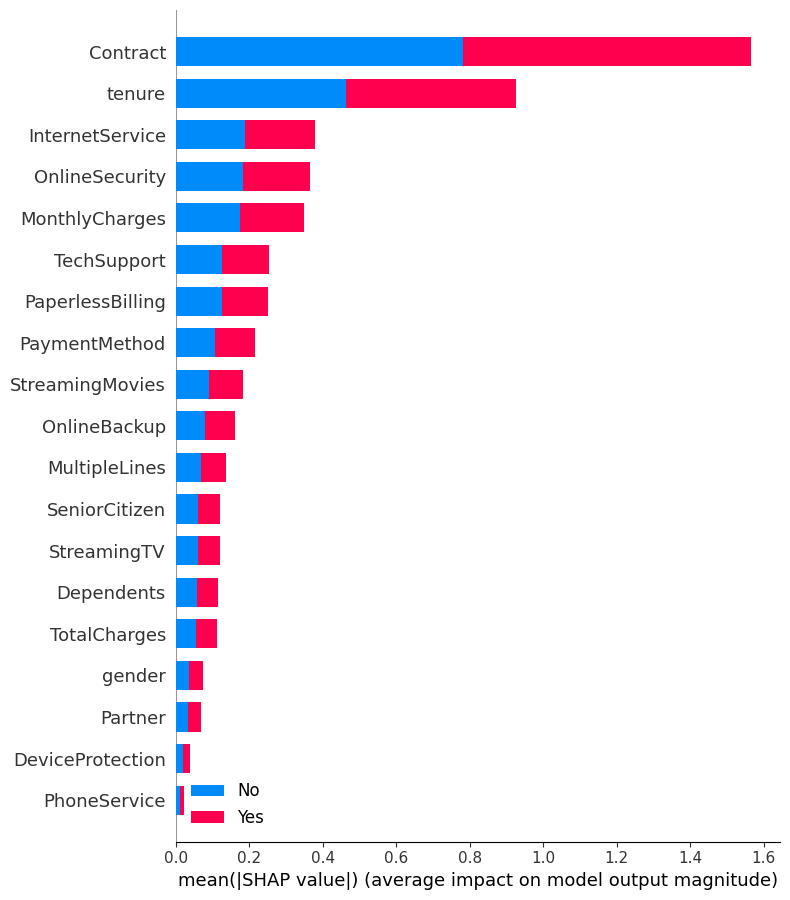

In [ ]:
# Run SHAP plots if the below flag is set to True
shap_enabled = True
if shap_enabled:
    # Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
    train_sample = X_train.sample(n=min(100, X_train.shape[0]), random_state=65846607)

    # Sample some rows from the validation set to explain. Increase the sample size for more thorough results.
    example = X_val.sample(n=min(100, X_val.shape[0]), random_state=65846607)

    # Use Kernel SHAP to explain feature importance on the sampled rows from the validation set.
    predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=X_train.columns))
    explainer = KernelExplainer(predict, train_sample, link="logit")
    shap_values = explainer.shap_values(example, l1_reg=False, nsamples=500)
    summary_plot(shap_values, example, class_names=model.classes_)

# Confusion matrix, ROC and Precision-Recall curves for test data

In [ ]:
#Model Predictions

y_pred = model.predict(X_test)

In [ ]:
#Confusion Matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted   No  Yes
Actual             
No         845  188
Yes        138  236


In [ ]:
#Classification Report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          No       0.86      0.82      0.84      1033
         Yes       0.56      0.63      0.59       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.71      1407
weighted avg       0.78      0.77      0.77      1407



In [ ]:
#Mapping labels to binary values

y_test_mapped = y_test.map({'Yes': 1, 'No': 0})
map_func = np.vectorize(lambda x: 1 if x == 'Yes' else 0)
y_pred_mapped= map_func(y_pred)

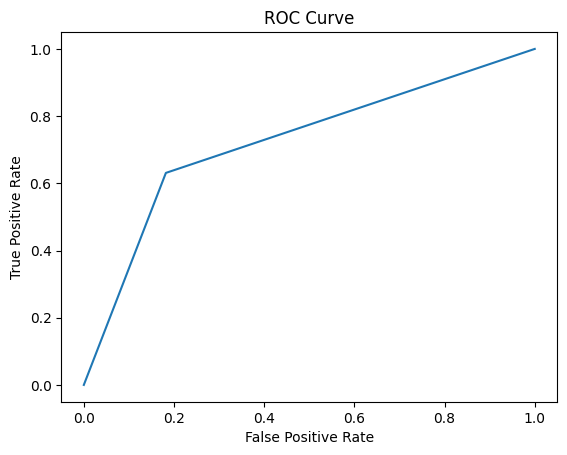

In [ ]:
# Plotting ROC Curve

fpr, tpr, threshold= roc_curve(y_test_mapped, y_pred_mapped)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

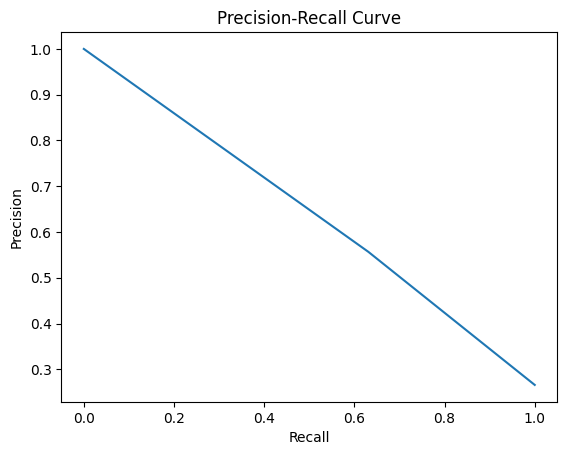

In [ ]:
#Plotting Precision-Recall Curve

precision, recall, thresholds = precision_recall_curve(y_test_mapped, y_pred_mapped)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()